<h1 style="font-size:24px; color:#8B0000; text-decoration:underline; font-weight:bold;">
  Setup environment
</h1>

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

In [2]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise
import pandas as pd

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader,Dataset
from monai.networks.nets import AutoEncoder
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    RandFlipd,
    RandRotated,
    RandZoomd,
    ScaleIntensityd,
    EnsureTyped,
    EnsureTyped,
    ScaleIntensityRangePercentilesd,
    Resized,
    Lambda,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /home/<username>/APP/miniconda3/envs/training_mri_to_cbct/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.


In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h1 style="font-size:24px; color:#8B0000; text-decoration:underline; font-weight:bold;">
  Get data
</h1>

In [4]:
mount_point = "/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT"
col = "img_fn"

df_train_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/train.csv") 
df_val_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/valid.csv")  
df_test_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT/training_CBCT/test.csv")

train_datadict=[]
for i in range(len(df_train_cbct[col])):
    train_datadict.append({"img":os.path.join(mount_point,df_train_cbct[col][i])})
 
val_datadict=[]   
for i in range(len(df_val_cbct[col])):
    val_datadict.append({"img":os.path.join(mount_point,df_val_cbct[col][i])})

In [12]:
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["img"],
        "gaus": torch.tensor(random_noise(d["img"], mode="gaussian", var=0.001), dtype=torch.float32),
        # "s&p": torch.tensor(random_noise(d["img"], mode="s&p", amount=0.01, salt_vs_pepper=0.5), dtype=torch.float32),
        "speckle": torch.tensor(random_noise(d["img"], mode="speckle", var=0.5), dtype=torch.float32),
        # "poisson": torch.tensor(random_noise(d["img"]* 10, mode="poisson")/ 10, dtype=torch.float32),
    }
)

train_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        EnsureChannelFirstd(keys=["img"]),
        EnsureTyped(keys=['img']),
        RandRotated(keys=["img"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipd(keys=["img"], spatial_axis=0, prob=0.5),
        RandZoomd(keys=["img"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        Resized(keys=['img'], spatial_size=(256, 256, 256)),
        ScaleIntensityRangePercentilesd(keys=['img'], lower=0.0, upper=100.0, b_min=0.0, b_max=1.0), 
        NoiseLambda,
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        EnsureChannelFirstd(keys=["img"]),
        ScaleIntensityd(keys=["img"]),
        EnsureTyped(keys=["img"]),
        NoiseLambda,
    ]
)

In [13]:
batch_size = 2
num_workers = 4

train_ds = Dataset(train_datadict, train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = Dataset(val_datadict, val_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Original Image Shape:  torch.Size([1, 256, 256, 256])
Gaussian Noise Image Shape:  torch.Size([1, 256, 256, 256])
Salt and Pepper Noise Image Shape:  torch.Size([1, 256, 256, 256])


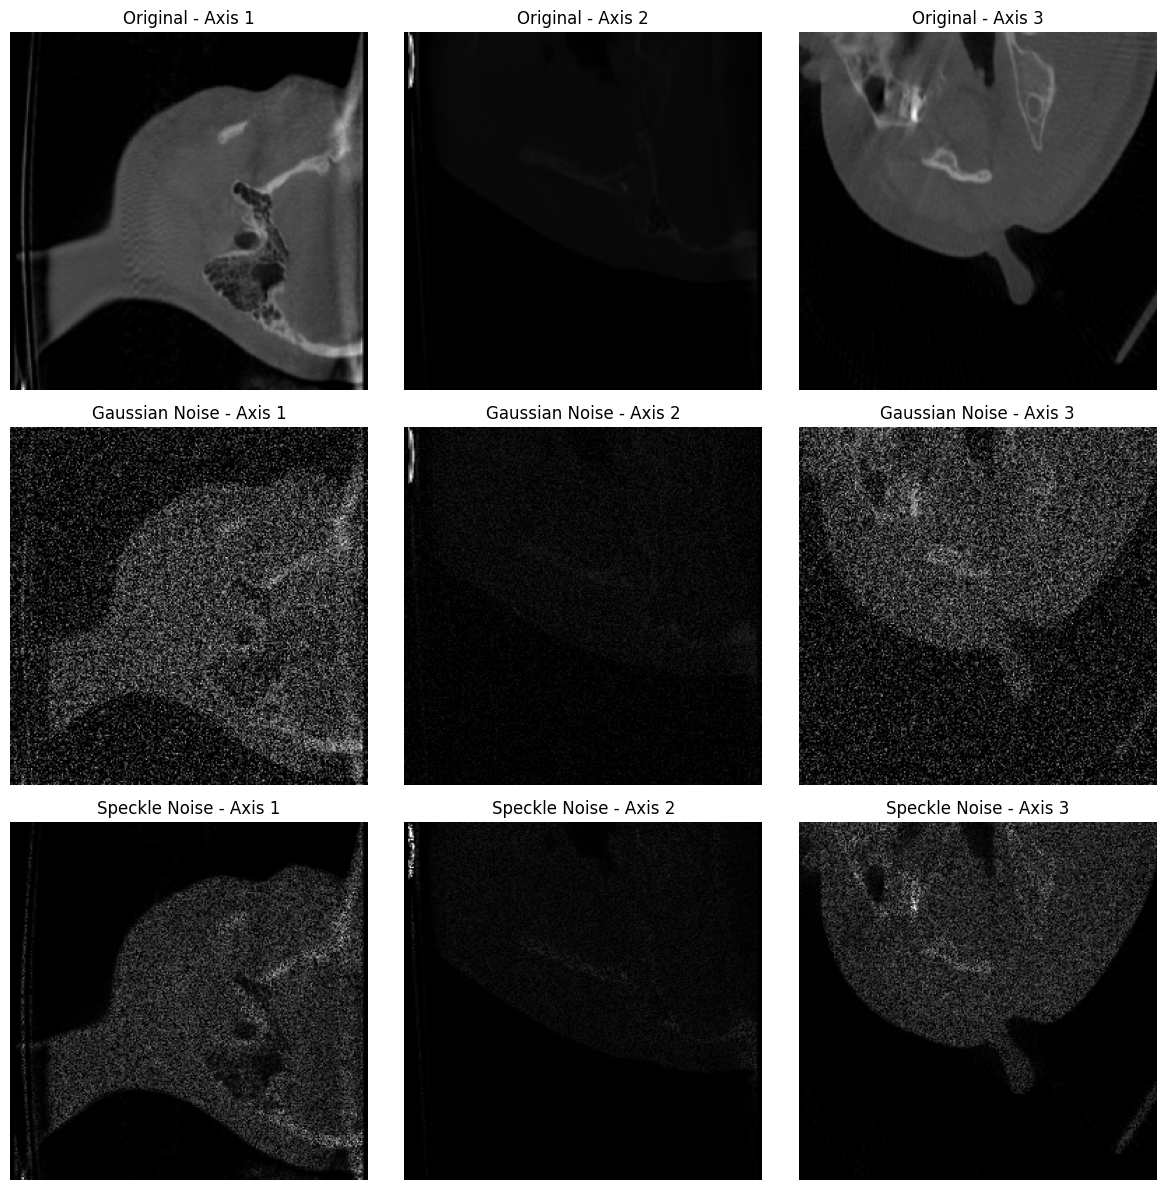

In [14]:
# train_data = [data["img"] for data in train_ds]
# test_data = [data["img"] for data in train_ds]

# Original and transformed images
for data in train_ds :
    img_ori = data["orig"]
    img_after_gaus = data["gaus"]
    # img_after_sp = data["s&p"]
    img_after_speekle = data["speckle"]
    # img_after_poisson = data["poisson"]

    # Print shapes and types for debugging
    print("Original Image Shape: ", img_ori.shape)
    print("Gaussian Noise Image Shape: ", img_after_gaus.shape)
    print("Salt and Pepper Noise Image Shape: ", img_after_speekle.shape)
    

    # Visualizing the images
    slice = 128
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    # Original images
    axs[0, 0].imshow(img_ori[0, slice, :, :], cmap="gray")
    axs[0, 0].set_title("Original - Axis 1")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(img_ori[0, :, slice, :], cmap="gray")
    axs[0, 1].set_title("Original - Axis 2")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(img_ori[0, :, :, slice], cmap="gray")
    axs[0, 2].set_title("Original - Axis 3")
    axs[0, 2].axis("off")

    # Gaussian noise images
    axs[1, 0].imshow(img_after_gaus[0, slice, :, :], cmap="gray")
    axs[1, 0].set_title("Gaussian Noise - Axis 1")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(img_after_gaus[0, :, slice, :], cmap="gray")
    axs[1, 1].set_title("Gaussian Noise - Axis 2")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(img_after_gaus[0, :, :, slice], cmap="gray")
    axs[1, 2].set_title("Gaussian Noise - Axis 3")
    axs[1, 2].axis("off")

    # Speckle noise images
    axs[2, 0].imshow(img_after_speekle[0, slice, :, :], cmap="gray")
    axs[2, 0].set_title("Speckle Noise - Axis 1")
    axs[2, 0].axis("off")

    axs[2, 1].imshow(img_after_speekle[0, :, slice, :], cmap="gray")
    axs[2, 1].set_title("Speckle Noise - Axis 2")
    axs[2, 1].axis("off")

    axs[2, 2].imshow(img_after_speekle[0, :, :, slice], cmap="gray")
    axs[2, 2].set_title("Speckle Noise - Axis 3")
    axs[2, 2].axis("off")
    
    # # S&P noise images
    # axs[2, 0].imshow(img_after_sp[0, slice, :, :], cmap="gray")
    # axs[2, 0].set_title("Salt and Pepper Noise - Axis 1")
    # axs[2, 0].axis("off")

    # axs[2, 1].imshow(img_after_sp[0, :, slice, :], cmap="gray")
    # axs[2, 1].set_title("Salt and Pepper Noise - Axis 2")
    # axs[2, 1].axis("off")

    # axs[2, 2].imshow(img_after_sp[0, :, :, slice], cmap="gray")
    # axs[2, 2].set_title("Salt and Pepper Noise - Axis 3")
    # axs[2, 2].axis("off")
    
    # # Poisson noise images
    # axs[4, 0].imshow(img_after_poisson[0, slice, :, :], cmap="gray")
    # axs[4, 0].set_title("Poisson Noise - Axis 1")
    # axs[4, 0].axis("off")

    # axs[4, 1].imshow(img_after_poisson[0, :, slice, :], cmap="gray")
    # axs[4, 1].set_title("Poisson Noise - Axis 2")
    # axs[4, 1].axis("off")

    # axs[4, 2].imshow(img_after_poisson[0, :, :, slice], cmap="gray")
    # axs[4, 2].set_title("Poisson Noise - Axis 3")
    # axs[4, 2].axis("off")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    break